In [1]:
# Based on the Kaggle notebook template

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, os.path as osp

#data_dir = 'siim-covid19-detection'
data_dir = './data'
#data_dir = '/data/siim-covid19-detection'

n_files = 0
for dirname, _, filenames in os.walk(osp.join(os.getcwd(), data_dir)):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        n_files += 1
        
print(n_files)

5b32cf2930.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f84e46c75e24\142474790dc2\e34939f0a328.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f8567c73e039\13fc2dfcf065\243d84bb9946.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f85e11da3a46\cfd5b6551bb2\8ea57eaf946f.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f865b83af346\93635c0fac6e\a600ed075926.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f86b1c64bf80\81a288f7a1a8\01fc054e43dd.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f871e115903e\c48902f04d5f\fa9ccef257cf.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f87baaa34bec\93ca1aa7cb50\5bfab860f585.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f88994c368d4\dda86ade5e75\3dd07c4082ce.dcm
c:\Users\chris\OneDrive\_kaggle\siim-covid19-detection\./data\train\f8a3d75d02bc\6116a3c3a89a\030

In [2]:
import glob
# 3rd party libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# need to install extra dependencies / ensure compatibility 
# with pydicom (for reading dicom data files)
#!pip install pydicom pylibjpeg pylibjpeg-libjpeg
#!yes | conda install -c conda-forge gdcm
#!yes | conda install -c conda-forge openjpeg

import pydicom


import cv2
import PIL
import torch
import torchvision

torch.__version__, torch.cuda.is_available()

('1.8.1', True)

## Step 1: Understanding data formatting

There are four structures we need to comprehend:

1. the study directories and '.dcm' file structure.
1. the 'train_image_level.csv' file
1. the 'train_study_level.csv' file
1. the 'sample_submission.csv' file

In [3]:
df_train_image = pd.read_csv(osp.join(data_dir,'train_image_level.csv'))
df_train_study = pd.read_csv(osp.join(data_dir,'train_study_level.csv'))

In [4]:
df_train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [5]:
df_train_image.iloc[0]['boxes']

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [6]:
df_train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


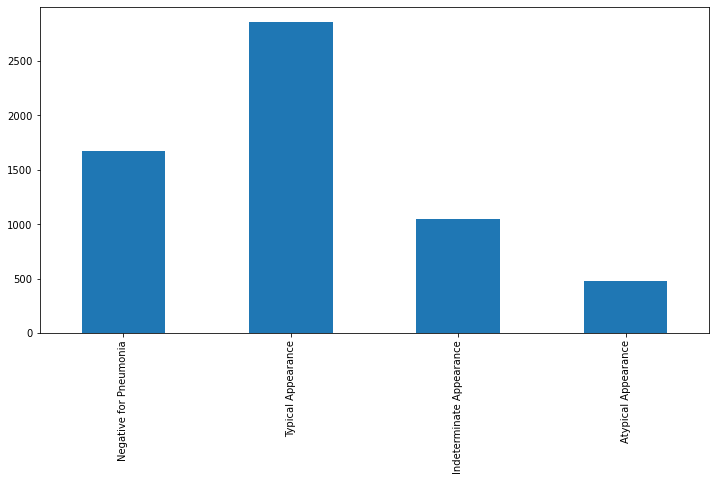

In [7]:
# view class distribution
fig = plt.figure(figsize=(12,6))
sums = df_train_study.sum()
del sums['id']
sums.plot.bar()
plt.show()

In [8]:
print(sums)
print(f'combined total occurence of all classes: {sums.sum()}, amount of samples in dataset: {len(df_train_study)}')

Negative for Pneumonia      1676
Typical Appearance          2855
Indeterminate Appearance    1049
Atypical Appearance          474
dtype: object
combined total occurence of all classes: 6054, amount of samples in dataset: 6054


We can see a clear bias towards the 'Typical' class and an under-representation of the 'Atypical' class.
Also clear is that each sample belongs to exactly one class, implying a multi-class problem, although the data brief describes the problem as multi-label as each prediction may include one or more classe(s).  

Problem -> boosting class equality datasynthesis is not currently feasible for the given data representation, would end up creating garbage data.

Conversely, not enough samples in the 'Atypical' class to allow for datapoints to be removed from other classes as we would end up with too little data.

Potential solution -> use image transforms on existing data to boost sample count.

It appears the 'train_image_level.csv' **(2)** and 'train_image_level.csv' **(3)** initially appear to beseperate classification problems due to the little crossover between data, although could potentially benefit from sequential approach, sharing data between models.

**(2)** is a classic multi-object detection problem where we need to make bounding box predictions for all specified occuring objects.

**(3)** A multi-label classification problem where the goal is to predict which class each study image belongs to.  While more straightforward than (2), the provided labels all present exactly one class per sample, while the problem on the other hand requires predictions for one or more labels.  This means we are effectively training on a multi-class problem, while producing inference for multi-label.  --> could potentially lead to bias towards predicting the amount of member classes closer to one.

need to test efficacy of training a model for (3) using predictions from (2) as this will greatly reduce computation requirements.  Can start by using the ground truth from (2) as the training data.

### (1) - dicom image files:

In [9]:
files = glob.glob(osp.join(data_dir,'train/**/*.dcm'), recursive=True)
files.sort()

len(files), files[0]

(6334, './data\\train\\00086460a852\\9e8302230c91\\65761e66de9f.dcm')

In [10]:
def read_dicom(file):
    ds = pydicom.dcmread(files[idx])
    ds.PhotometricInterpretation = 'YBR_FULL'
    img = ds.pixel_array
    return img

Problem - Not all of the .dcm files share the same formatting as some are compressed.  To fix, use conda to install openjpeg and gdcm. 

Do not install pylibjpeg at all as this causes conflicts with the pydicom package.

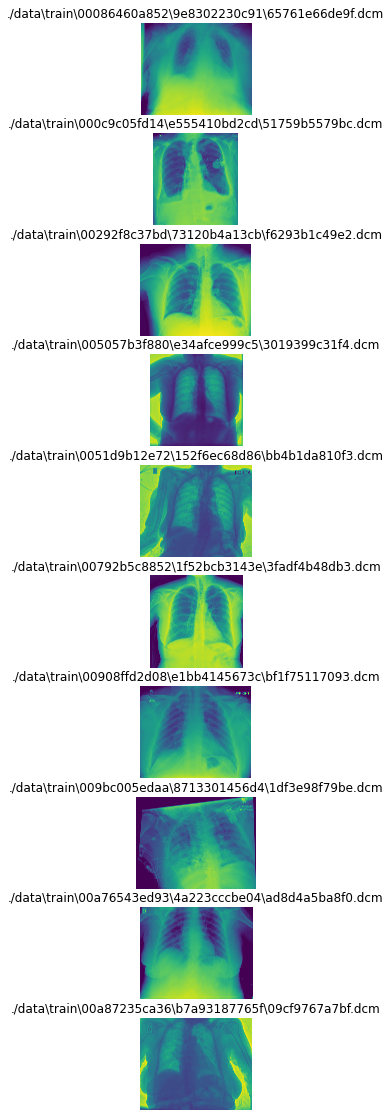

In [11]:
fig, axs = plt.subplots(10, 1, figsize=(20,20))
for idx, ax in enumerate(axs):
    img = read_dicom(files[idx])
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(files[idx])

In [12]:
img = read_dicom(files[0])
img

array([[23543, 23702, 23865, ..., 24228, 24080, 24702],
       [23936, 24166, 24175, ..., 24424, 24343, 24288],
       [24058, 24057, 24078, ..., 24240, 24333, 24389],
       ...,
       [13756, 13666, 13718, ..., 17513, 17383, 17656],
       [13937, 13799, 13758, ..., 17515, 17493, 17536],
       [13979, 14004, 14226, ..., 17597, 17580, 17537]], dtype=uint16)

The image format is 16-bit unsigned single channel images (monochrome).  To work as input we further need to convert to 8-bit rgb images.

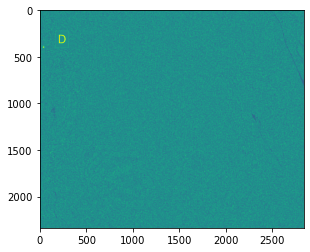

In [13]:
img = img.astype(np.uint8)

plt.imshow(img)
plt.show()

A simple cast to 8bit will destroy the image detail as it clips anyvalue outside of the 8bit range rather than scale it down.  We need to investigate other methods of conversion to preserve detail.

1). OpenCV conversion method.

Transform from single channel to three channel image, then rescale into 8bit range. 

(2336, 2836, 3)

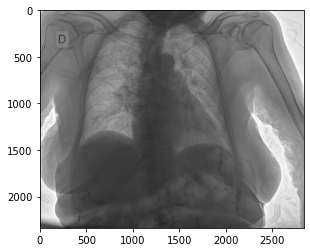

In [14]:
img = read_dicom(files[0])
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
cimg -= cimg.min()
cimg = cimg / cimg.max()
cimg *= 255
cimg = cimg.astype(np.uint8)
plt.imshow(cimg)
cimg.shape

2). Numpy conversion.

Only perform rescaling, leaving sinlge image channel

(array([[214, 216, 218, ..., 223, 221, 230],
        [219, 222, 222, ..., 226, 225, 224],
        [221, 221, 221, ..., 223, 225, 225],
        ...,
        [ 76,  75,  75, ..., 129, 127, 131],
        [ 78,  77,  76, ..., 129, 128, 129],
        [ 79,  79,  83, ..., 130, 130, 129]], dtype=uint8),
 (2336, 2836))

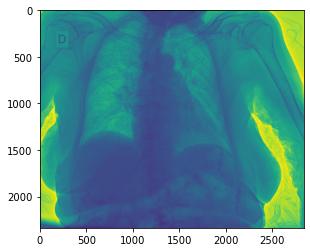

In [15]:
img = read_dicom(files[0])
img -= img.min()
img = img / img.max()
img *= 255
img = img.astype(np.uint8)
plt.imshow(img)
img, img.shape